In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

""" Linearize Seager's bulk formulas for surface fluxes.

See Richard's white paper for details  http://kage.ldeo.columbia.edu/Richard/TCC.pdf

Purpose: To estimate the changes in surface heat flux as CO2 increases
      QLH (latent heating) and QLW (longwave) changes are linearized as
          QLH' = dQLH/dTs * Ts' + dQLH/dU * U'
          QLW' = dQLW/dTs * Ts' + dQLW/df1 * f1'

       where Ts is surface ocean temperature, 
             U is surface windspeed and 
            f1 is a parameter which varies as CO2 varies
 -----------------------------------------------------------------------
 Method:
      We are using Seager's bulk formulas
         QLH = rhoa*Ce*L*(qs-qa)
         QLW = eps*sigma*Ta^4*(f1-f2*sqrt(e))*(1-a*C^2) + 4*eps*sigma*Ts^3(Ts-Ta)
      where
   Ta = surface air temperature
   qs = saturation specific humidity
   qa = surface air humidity evaluated at Ta
   f1 = parameter allowing for change in CO2 affecting emissivity 
         and
    e = emissivity
    C = cloudiness
    
    additional relationships:  
   Ta = Ts - delta
   qa = r*qs
    e = qa*ps/0.622, where ps is surface pressure
   qs = 0.622*es/ps
   es = es0*exp(17.67*(Ts-T0)/(Ts-T0+243.5))
"""
rhoa = 1.225; cE = 0.00125; L = 2.5e6
eps = 0.97; sigma = 5.67e-8
r = 0.8; ps = 1000; es0 = 6.11
delta = 1.0
f2 = 0.05
# 'a' should decrease when deep convection happens above 28 degC
# a = Ts-T0;a[a>28] = 40;a[a<=28] = 80;a = 0.01*a
a = 0.6
C = 0.6

In [2]:
# basic parameters
T0 = 273.15
f1bar = 0.39
Ubar = 6.0
Tsbar = T0 + 25

In [3]:
# discretizations of variables, Ts, U, f1
def make_var(vmean,n,d):
    """Make a discretized array of length 2n in [vmean-d,vmean+d]."""
    return vmean + d*np.arange(-n,n+1)/n

nTs=50;dTs=5;Ts = make_var(Tsbar,nTs,dTs)
Tsprime = Ts - Tsbar

nU=40;dU=4;U = make_var(Ubar,nU,dU)
Uprime = U - Ubar

nf1=30;df1=.006;f1 = make_var(f1bar,nf1,df1)
f1prime = f1 - f1bar

In [4]:
# Find linearization of Q_LH (latent heating)

const1 = rhoa * cE * L * (1-r)

def f_es(T):
    return es0*np.exp(17.67*(T-T0)/(T-T0+243.5))

def f_qs(T):
    return 0.622*f_es(T)/ps

def f_dqsdT(T):
    return f_qs(T)*(17.67*243.5)/(T-T0+243.5)**2

def f_QLH(T,U):
    return const1 * U * f_qs(T)

def f_dQLHdU(T,U):
    return const1 * f_qs(T)

def f_dQLHdT(T,U):
    return const1 * U * f_dqsdT(T)

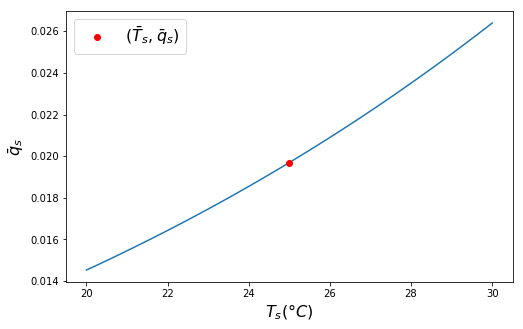

In [5]:
qs = f_qs(Ts)
qsbar = f_qs(Tsbar)

plt.figure(figsize=(8,5))
plt.plot(Ts-T0,qs)
plt.plot(Tsbar-T0,qsbar,'ro',label=r'$(\bar T_s,\bar q_s)$')
plt.legend(loc='upper left', fontsize=16)
plt.ylabel(r'$\bar q_s$', fontsize=16)
plt.xlabel(r'$T_s(\degree C)$', fontsize=16)
plt.show()

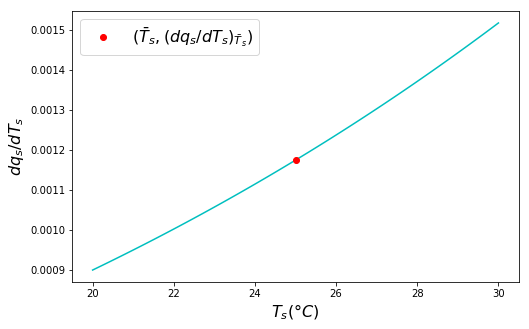

In [6]:
adqsdT = f_dqsdT(Ts)
adqsdTbar = adqsdT[nTs]   

plt.figure(figsize=(8,5))
plt.plot(Ts-T0,adqsdT,'c')
plt.plot(Tsbar-T0,adqsdTbar,'ro',label=r'$(\bar T_s,(d q_s/dT_s)_{\bar T_s}$)')
plt.ylabel(r'$d q_s/dT_s$', fontsize=16)
plt.xlabel(r'$T_s(\degree C)$', fontsize=16)
plt.legend(loc='upper left', fontsize=16)
plt.show()

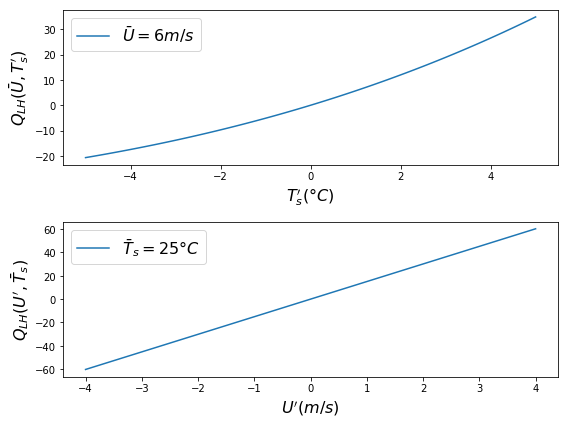

In [7]:
# QLHprime = QLH_umTp + QLH_upTm
adQLHdTs = f_dQLHdT(Ts,Ubar)
adQLHdU  = f_dQLHdU(Tsbar,U)

QLH_umTp = adQLHdTs * Tsprime
QLH_upTm = adQLHdU  * Uprime

fig = plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(Tsprime,QLH_umTp,label=r'$\bar U = 6 m/s$')
plt.ylabel(r'$Q_{LH} (\bar U, T_s^{\prime})$', fontsize=16)
plt.xlabel(r'$T_s^{\prime}(\degree C)$', fontsize=16)
plt.legend(loc='upper left', fontsize=16)

plt.subplot(212)
plt.plot(Uprime,QLH_upTm,label=r'$\bar T_s = 25\degree C$')
plt.legend(loc='upper left', fontsize=16)
plt.ylabel(r'$Q_{LH} (U^{\prime}, \bar T_s)$', fontsize=16)
plt.xlabel(r'$U^{\prime}(m/s)$', fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
# Find linearization of Q_LW (longwave)
const2 = eps*sigma*(1 - a*C**2) 

def f_qa(T):
    return r * f_qs(T)

def f_Ta(T):
    return T - delta

def f_ebar(T):
    qa = r * f_qs(T)
    return r * f_qs(T) * ps / 0.622

def f_QLW1(T,f):
    Ta = f_Ta(T)
    return const2*Ta**4*(f - f2*np.sqrt(f_ebar(T)))

def f_QLW2(T):
    return 4*eps*sigma*T**3*(T - f_Ta(T))

def f_QLW(T,f):
    return f_QLW1(T,f) + f_QLW2(T)

def f_dQLWdf(T):
    return const2 * T**4

def f_dQLWdT(T,f):
    ebar1 = f_ebar(T)
    qs1 = f_qs(T)
    dqsdT1 = f_dqsdT(T)
    return const2 * T**3*(4*f - f2*np.sqrt(ebar1*(4 + T*dqsdT1/2/qs1))) + 12*eps*sigma*T**2*delta


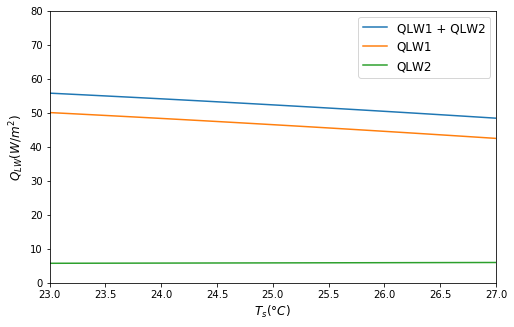

In [9]:
plt.figure(figsize=(8,5))
plt.plot(Ts-T0,f_QLW(Ts,f1bar),label='QLW1 + QLW2')
plt.plot(Ts-T0,f_QLW1(Ts,f1bar),label='QLW1')
plt.plot(Ts-T0,f_QLW2(Ts),label='QLW2')
plt.legend(loc='upper right', fontsize=12)
plt.ylabel(r'$Q_{LW}(W/m^2)$', fontsize=12)
plt.xlabel(r'$T_s(\degree C)$', fontsize=12)
plt.axis([23, 27, 0, 80])
plt.show()

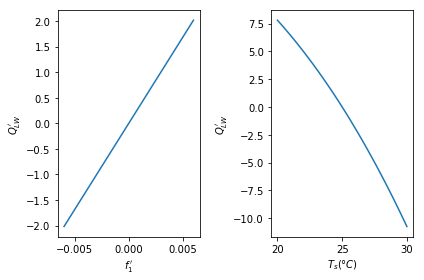

In [10]:
# discrete derivatives:
QLW_f1 = f_QLW(Tsbar,f1)
QLW_Ts = f_QLW(Ts,f1bar)
QLWbar = f_QLW(Tsbar,f1bar)

plt.subplot(121)
plt.plot(f1-f1bar,QLW_f1-QLWbar)
plt.xlabel(r'$f_1^{\,\prime}$')
plt.ylabel(r'$Q_{LW}^{\,\prime}$')
plt.subplot(122)
plt.plot(Ts-T0,QLW_Ts-QLWbar)
plt.xlabel(r'$T_s(\degree C)$')
plt.ylabel(r'$Q_{LW}^{\,\prime}$')
plt.tight_layout()
plt.show()

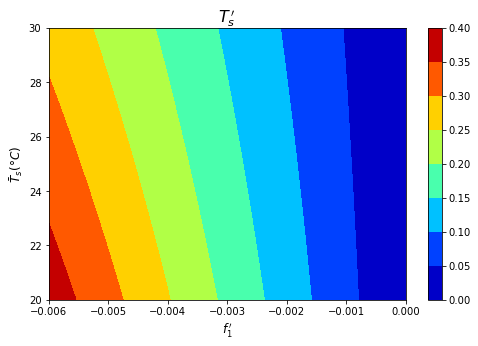

In [11]:
# set Q'_LW + Q'_LH = 0, solve for Ts' (assuming U'=0)
#       Q'_LW = ALW(Tsbar,f1bar)* Tsprime + BLW(Tsbar) * f1prime
#       Q'_LW = ALH(Tsbar,Ubar) * Tsprime + BLH(Tsbar) * Uprime

ALH = f_dQLHdT(Ts,Ubar)
ALW = f_dQLWdT(Ts,f1bar)
BLW = f_dQLWdf(Ts)
#print(Ts)
Ts_equil = np.zeros((2*nTs+1,2*nf1+1))
for i in range(0, 2*nTs+1):
    Ts_equil[i,:] = - BLW[i] * f1prime / (ALH[i] + ALW[i])
 
Ts_equil[Ts_equil<0] = 0

plt.figure(figsize=(8,5))
plt.title(r'$T_s^{\,\prime}$', fontsize=16)
dp=plt.contourf(f1prime,Ts-T0,Ts_equil,cmap="jet")
plt.colorbar(dp)
plt.ylabel(r'$\bar T_s(\degree C)$', fontsize=12)
plt.xlabel(r'$f_1^{\,\prime}$', fontsize=12)
plt.axis([-.006,0,20, 30])
plt.savefig('Tsp.eps', format='eps', dpi=1000)
plt.show()

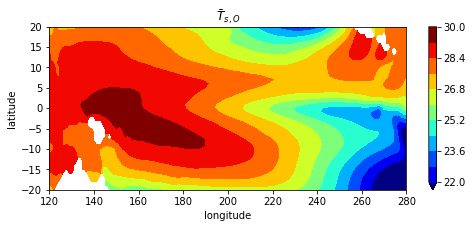

In [25]:
url = 'http://kage.ldeo.columbia.edu:81/expert/SOURCES/.LDEO/.ClimateGroup/.PROJECTS/.TCC/.ORAs4/.sst-clim.nc/.sst/dods'
dsst = xr.open_dataset(url).sel(Y=slice(-20,20),X=slice(120,280))

plt.figure(figsize=(8,3))
dp=dsst.sst.plot.contourf(levels=11,cmap="jet",vmin=22,vmax=30,add_colorbar=0)
#,vmin=-2,vmax=2,add_colorbar=0)
plt.title(r'$\bar T_{s,O}$')
plt.ylabel('latitude');plt.xlabel('longitude')
cbar = plt.colorbar(dp)
plt.show()

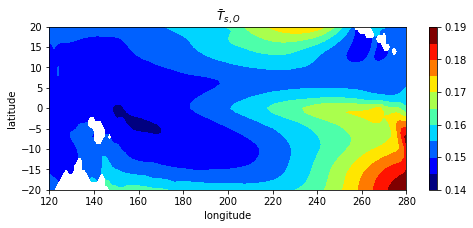

In [45]:
Tsb = 1.0*dsst.sst + T0
ALH = f_dQLHdT(Tsb,Ubar)
ALW = f_dQLWdT(Tsb,f1bar)
BLW = f_dQLWdf(Tsb)

f1p = -0.003
Tse = - BLW * f1p / (ALH + ALW)
dsst['Tse'] = Tse 

plt.figure(figsize=(8,3))
dp2=dsst.Tse.plot.contourf(levels=11,cmap="jet",add_colorbar=0)
plt.title(r'$\bar T_{s,O}$')
plt.ylabel('latitude');plt.xlabel('longitude')
cbar = plt.colorbar(dp2)
plt.show()